# Kmer Pipeline Demo

This notebook will demonstrate how to use the `kmerfeatures` pipeline for the analysis of protein sequence files.

### Pipeline Workflow

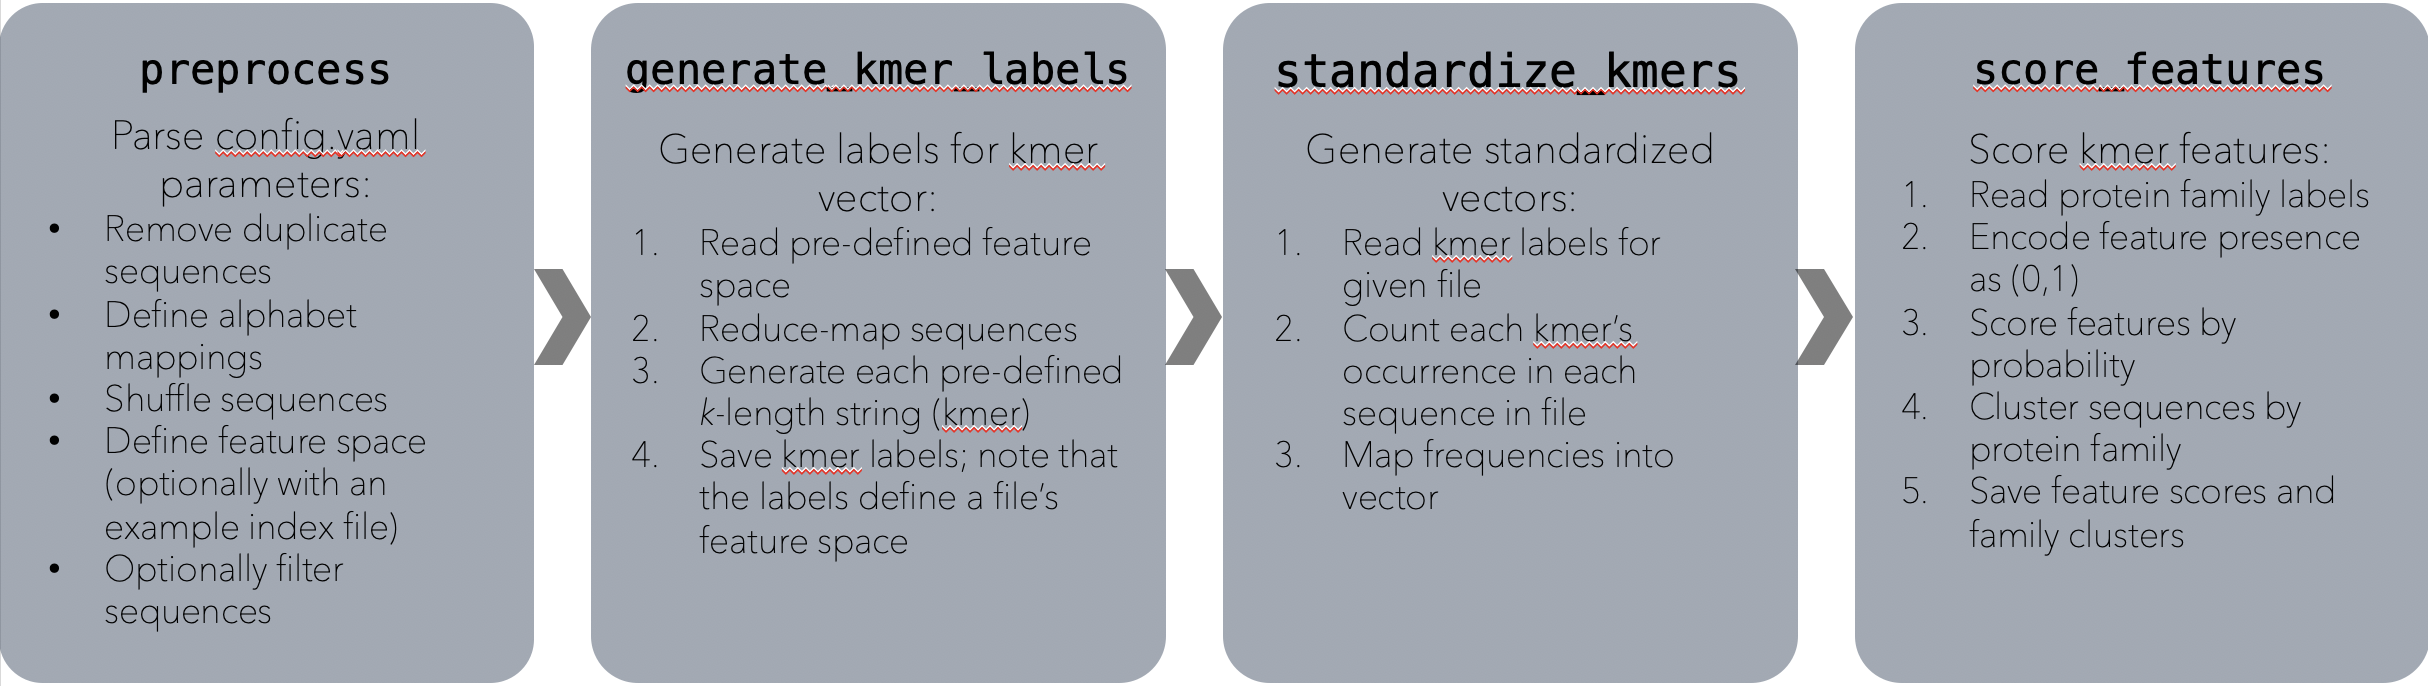

### Setup

In [1]:
# built-in imports
import json
from glob import glob
from datetime import datetime
from itertools import (product, repeat)
from multiprocessing import Pool
from os import makedirs
from os.path import (basename, dirname, exists, join, splitext)

# external libraries
import kmerfeatures as kmf
import numpy as np
from pandas import DataFrame
from Bio import SeqIO
from snakemake.io import expand

In [12]:
# define config (note: in the snakemake workflow,
#                this is handled through the yaml file)

config = {
    
    # input handling
    'input': {
        # location of all input fasta files
        'fasta_dir': "../input/demo",
        'example_index_file': False,
        'feature_set': False,
        'file_extensions': ['fasta', 'fna', 'faa', 'fa']
    },
    
    # kmer pipeline parameters
    'k': 14,
    'start': False,
    'end': False,
    'nucleotide': False,
    'map_function': 'reduced_alphabet_0',  # choices: 0-5
    'randomize_alphabet': False,
    'min_rep_thresh': 1,
    'walk': False,
    'full_kmer_list': False,
    'processes': 2,
    
    # output handling
    'output': {
        'save_dir': "../output/demo",
        'verbose': True,
        'format': 'simple',  # choices: ['simple', 'gist', 'sieve']
        'filename': False,
        'filter_duplicates': True,
        'n_terminal_file': False,
        'shuffle_n': False,
        'shuffle_sequences': False,
        'kmer_output': True,
    },
    
    # scoring parameters
    'score': {
        'labels': None,
        'lname': None  # label name
    }

}

### Rule 0: Get files

Before going through the workflow, we glob all filenames that end in the pre-defined file extensions and/or the extension and `.gz`. Filename globbing is demonstrated via a directory containing a single FASTA file, `12485-2500Genomes-nrfH_protein.fasta`, and a gzipped FAA file, `AmoA_AOA.faa.gz`.

In [4]:
# collect all fasta-like files, unzipped filenames, and basenames
input_files = glob(join(config['input']['fasta_dir'], "*"))
compressed = [fa for fa in input_files if fa.endswith('.gz')]
uncompressed = [fa.rstrip('.gz') for fa, ext
                in product(input_files, config['input']['file_extensions'])
                if fa.rstrip('.gz').endswith(f".{ext}")]

print("compressed files:\t", compressed)
print("uncompressed files:\t", uncompressed)

compressed files:	 ['../input/demo/AmoA_AOA.faa.gz']
uncompressed files:	 ['../input/demo/12485-2500Genomes-nrfH_protein.fasta', '../input/demo/AmoA_AOA.faa']


Next, file paths are stripped of directory paths and extensions into the file base name, known in Snakemake as a file's **wildcard**.

In [5]:
# map extensions to basename (basename.ext.gz -> {basename: ext})
unzipped_ext_map = {
    splitext(splitext(basename(f))[0])[0]: splitext(
        splitext(basename(f))[0]
        )[1].lstrip('.') for f in compressed
        }
fasta_ext_map = {splitext(basename(f))[0]: splitext(basename(f))[1].lstrip('.')
                 for f in uncompressed}
UZS = list(unzipped_ext_map.keys())
FAS = list(fasta_ext_map.keys())

print("compressed filename wildcards:\t\t", UZS)
print("uncompressed filename wildcards:\t", FAS)

compressed filename wildcards:		 ['AmoA_AOA']
uncompressed filename wildcards:	 ['12485-2500Genomes-nrfH_protein', 'AmoA_AOA']


Finally, the output (save) path is defined. (Note: this may change in future versions.)

In [6]:
# define output directory (helpful for multiple runs)
out_dir = join(config['output']['save_dir'],
               config['map_function'],
               f"k-{config['k']:02}")

print("output directory:\t", out_dir)

# validity check
if config['map_function'] not in kmf.alphabet.ALPHABETS.keys():
    raise ValueError("Invalid alphabet specified; alphabet must be a"
                     " string in the form 'reduced_alphabet_n' where"
                     " n is an integer between 0 and"
                     f" {len(kmf.alphabet.ALPHABETS)}.")

output directory:	 ../output/demo/reduced_alphabet_0/k-14


### Rule 0.5: Unzip files

Any zipped files detected by the above are automatically unzipped.

**Snakemake code:**

    # if any files are gzip compressed, unzip them
    if len(UZS) > 0:
        rule unzip:
            input:
                # lambda wildcards: '{0}_hmm'.format(dict[wildcards.run])
                lambda wildcards: join(config['input']['fasta_dir'], f"{wildcards.uz}.{unzipped_ext_map[wildcards.uz]}.gz")
            output:
                join(config['input']['fasta_dir'], "{uz}.{uzext}")
            params:
                outdir=join(config['input']['fasta_dir'], 'compressed')
            shell:
                "mkdir {params.outdir} && cp {input} {params.outdir} && gunzip -c {input} > {output}"
                
To run an analogous version of Snakemake syntax in Python, see below:

In [9]:
# if any files are gzip compressed, unzip them
if len(UZS) > 0:
    for uz in UZS:
        input_ = join(config['input']['fasta_dir'], f"{uz}.{unzipped_ext_map[uz]}.gz")
        output_ = join(config['input']['fasta_dir'], f"{uz}.{unzipped_ext_map[uz]}")
        outdir = join(config['input']['fasta_dir'], 'compressed')
        ! mkdir $outdir && cp $input_ $outdir && gunzip -c $input_ > $output_
        
        print("input:\t", input_)
        print("output:\t", output_)

input:	 ../input/demo/AmoA_AOA.faa.gz
output:	 ../input/demo/AmoA_AOA.faa


The above step successfully creates the unzipped output:

In [10]:
exists("../input/demo/AmoA_AOA.faa")

True

### Rule 1: Preprocess

In this step, we parse user-defined parameters into an appropriate format for subsequent pipeline steps.

Parameter options include:
- `filter_duplicates`: Remove duplicate sequences
- `map_function`: Define alphabet mappings
- `k`: Define kmer length
- `min_rep_thresh`: Set threshold for minimum replicates required to include a feature in the final feature space
- `shuffle_sequences`: Shuffle sequences
    - `shuffle_n`: Define shuffle
- `example_index_file`: Use example index file to define feature space
- `filter_sequences`: Optionally filter sequences
- `start` and `end`: Define sequence start and end points
- `nucleotide`: Allow nucleotide mapping

The Snakemake code is not shown due to length, but the converted Python-ized code is shown below:

In [18]:
# read and process parameters from config
for fa in FAS:
    
    # define i/o for each detected file
    input_fasta = join(config['input']['fasta_dir'], f"{fa}.{fasta_ext_map[fa]}")
    output_data = join(out_dir, "processed", f"{fa}.json")
    output_desc = join(out_dir, "processed", f"{fa}_description.json")
    
    print("input file:\t", input_fasta)
    print("output file:\t", output_data)
    
    start_time = datetime.now()

    # read fasta file
    seq_list, id_list = kmf.io.read_fasta(input_fasta)

    # if random alphabet specified, implement randomization
    if config['randomize_alphabet']:
        rand_alphabet = kmf.transform.randomize_alphabet(config['input']['map_function'])
        map_function = [residues, map_name, rand_alphabet]
    else:
        map_function = config['map_function']

    # if no feature set is specified, define feature space
    if not config['input']['feature_set']:
        # prefilter fasta to cut down on the size of feature set
        filter_dict = kmf.features.define_feature_space(
            {k: v for k, v in zip(id_list, seq_list)},
            config['k'],
            map_function=map_function,
            start=config['start'],
            end=config['end'],
            min_rep_thresh=config['min_rep_thresh'],
            verbose=config['output']['verbose'],
            processes=config['processes']
            )
        filter_list = list(filter_dict.keys())
        assert len(filter_list) > 0, "Invalid feature space; terminating."
    else:
        # read in list of ids to use from file; NO FORMAT CHECK
        filter_list = []
        with open(config['input']['feature_set'], "r") as f:
            for line in f.readlines():
                filter_list.append(line.split()[0])

    # optional indexfile with IDs of good feature output examples
    if config['input']['example_index_file']:
        example_index = kmf.io.read_example_index(
            config['input']['example_index_file']
            )
    else:
        example_index = {}

    # loop thru seqs, apply input params to preprocess seq list
    seen = []  # filter duplicates
    save_data = dict()

    # define recursive and nonrecursive saving patterns for params
    recursive = ['sequences', 'ids', 'residues']
    nonrecursive = ['map_function', 'k', 'example_index', 'filter_list']
    all_dsets = recursive + nonrecursive

    for i in range(len(seq_list)):
        seq = seq_list[i]
        sid = id_list[i]

        # ignore duplicate ids
        if config['output']['filter_duplicates'] and sid in seen:
            continue
        seen.append(sid)

        seqs = [seq]
        sids = [sid]

        # shuffle the N-terminal sequence n times
        if config['output']['shuffle_n']:
            example_index[id] = 1.0
            scid_list, scramble_list, example_index = kmf.transform.scramble_sequence(
                sid, seq[:30], n=config['output']['shuffle_n'],
                example_index=example_index
                )
            seqs += scramble_list
            sids += scid_list

            # include shuffled sequences in output
            if config['output']['shuffle_sequences']:
                filename = join(out_dir, 'shuffled',
                                wildcards.fa, "%s_shuffled.fasta" % sid)
                if not exists(dirname(filename)):
                    makedirs(dirname(filename))
                with open(filename, "w") as f:
                    for i in range(len(sids)):
                        f.write(">%s\n%s\n" % (sids[i], seqs[i]))

        # run SIEVE on the wt and each shuffled sequence
        if config['output']['n_terminal_file']:
            sids_n, seqs_n = kmf.transform.make_n_terminal_fusions(
                sid, config['output']['n_terminal_file']
                )
            seqs += seqs_n
            sids += sids_n
        residues = None
        if config['nucleotide']:
            residues = "ACGT"

        # populate dictionary for json save file
        to_save = [seqs, sids, residues]
        save_label = recursive
        for dset, label in zip(to_save, save_label):
            if label in save_data.keys() and save_data[label] is not None:
                save_data[label] = save_data[label] + dset
            else:
                save_data[label] = dset

    # save variables not generated in loop
    for dset, label in zip(
        [map_function, config['k'], example_index, filter_list],
        nonrecursive
    ):
        save_data[label] = dset

    # save all parameters into json
    if not exists(join(out_dir, "processed")):
        makedirs(join(out_dir, "processed"))
    with open(output_data, 'w') as f:
        json.dump(save_data, f)

    # read and save fasta descriptions into dataframe
    try:
        desc = kmf.utils.parse_fasta_description(input_fasta)
        desc.to_json(output_desc)
    except AttributeError:  # if no description exists > empty df
        DataFrame([]).to_json(output_desc)

    # record script runtime
    end_time = datetime.now()
    print(f"start time:\t{start_time}")
    print(f"end time:\t{end_time}")
    print(f"total time:\t{kmf.utils.format_timedelta(end_time - start_time)}\n")

input file:	 ../input/demo/12485-2500Genomes-nrfH_protein.fasta
output file:	 ../output/demo/reduced_alphabet_0/k-14/processed/12485-2500Genomes-nrfH_protein.json
Feature space: 3336 kmers with more than 1 representation in 67 sequences
start time:	2021-04-02 13:00:22.040372
end time:	2021-04-02 13:00:23.813676
total time:	0h 00m 01.773s

input file:	 ../input/demo/AmoA_AOA.faa
output file:	 ../output/demo/reduced_alphabet_0/k-14/processed/AmoA_AOA.json
Feature space: 202 kmers with more than 1 representation in 1 sequences
start time:	2021-04-02 13:00:23.813914
end time:	2021-04-02 13:00:25.467964
total time:	0h 00m 01.654s



In [19]:
# check to see if output files created
for fa in FAS:
    print(exists(join(out_dir, "processed", f"{fa}.json")))

True
True


### Rule 2: Generate kmer labels

In this step, kmer labels for the kmers in the generated feature space are saved.

As previously, the Python-ized version of this Snakemake rule is demonstrated below:

In [22]:
for fa in FAS:
    input_params = join(out_dir, "processed", f"{fa}.json")
    output_labels = join(out_dir, "labels", f"{fa}.txt")
    print("input file:\t", input_params)
    print("output file:\t", output_labels)
    
    start_time = datetime.now()

    # read processed features
    with open(input_params, 'r') as f:
        params = json.load(f)
        
    if not exists(join(out_dir, "labels")):
        makedirs(join(out_dir, "labels"))

    # generate labels only
    labels = kmf.transform.generate_labels(
        config['k'],
        map_function=params['map_function'],
        residues=params['residues'],
        filter_list=params['filter_list']
        )
    if config['output']['format'] == "simple":
        kmf.features.output_features(
            output_labels, "matrix", labels=labels
            )

    # record script runtime
    end_time = datetime.now()
    print(f"start time:\t{start_time}")
    print(f"end time:\t{end_time}")
    print(f"total time:\t{kmf.utils.format_timedelta(end_time - start_time)}\n")

input file:	 ../output/demo/reduced_alphabet_0/k-14/processed/12485-2500Genomes-nrfH_protein.json
output file:	 ../output/demo/reduced_alphabet_0/k-14/labels/12485-2500Genomes-nrfH_protein.txt
start time:	2021-04-02 13:02:19.851811
end time:	2021-04-02 13:02:19.856593
total time:	0h 00m 00.5s

input file:	 ../output/demo/reduced_alphabet_0/k-14/processed/AmoA_AOA.json
output file:	 ../output/demo/reduced_alphabet_0/k-14/labels/AmoA_AOA.txt
start time:	2021-04-02 13:02:19.856829
end time:	2021-04-02 13:02:19.858173
total time:	0h 00m 00.1s



In [23]:
# check that output files were created correctly
for fa in FAS:
    print(exists(join(out_dir, "labels", f"{fa}.txt")))

True
True


### Rule 3: Standardize kmers

In this step, the feature spaces for each individual file are used to parse all files in the directory. For instance, the `12485-2500Genomes-nrfH_protein` feature set is used to kmerize all sequences in both `12485-2500Genomes-nrfH_protein` and `AmoA_AOA` sets, and then the `AmoA_AOA` feature set is used to kmerize all sequences in both sequence files.

As previously, the Python-ized version of this Snakemake rule is demonstrated below:

In [29]:
for fa in FAS:
    input_kmers = join(out_dir, "labels", f"{fa}.txt")
    input_params = join(out_dir, "processed", f"{fa}.json")
    input_fastas = uncompressed
    output_files = expand(join(out_dir, "features", f"{fa}", "{fa2}.json"), fa2=FAS)
    print("input file:\t", input_kmers)
    print("output files:\t", output_files)
    
    if not exists(join(out_dir, "features", f"{fa}")):
        makedirs(join(out_dir, "features", f"{fa}"))

    start_time = datetime.now()

    # get kmers for this particular set of sequences
    kmers = kmf.io.read_output_kmers(input_kmers)

    # read processed features
    with open(input_params, 'r') as f:
        params = json.load(f)

    # sort i/o lists to match wildcard order
    fastas = sorted(input_fastas)
    outfiles = sorted(output_files)

    # revectorize based on full kmer list
    results = {'seq_id': [], 'vector': []}
    for i, fa in enumerate(fastas):
        seq_list, id_list = kmf.io.read_fasta(fa)
        for seq, sid in zip(seq_list, id_list):
            results['seq_id'] += [sid]
            results['vector'] += [kmf.transform.vectorize_string(
                seq,
                k=config['k'],
                start=config['start'],
                end=config['end'],
                map_function=params['map_function'],
                filter_list=kmers,  # params['filter_list'],
                verbose=False,  # way too noisy for batch process
            )]

        with open(outfiles[i], 'w') as f:
            json.dump(results, f)

    # record script runtime
    end_time = datetime.now()
    print(f"start time:\t{start_time}")
    print(f"end time:\t{end_time}")
    print(f"total time:\t{kmf.utils.format_timedelta(end_time - start_time)}\n")

input file:	 ../output/demo/reduced_alphabet_0/k-14/labels/12485-2500Genomes-nrfH_protein.txt
output files:	 ['../output/demo/reduced_alphabet_0/k-14/features/12485-2500Genomes-nrfH_protein/12485-2500Genomes-nrfH_protein.json', '../output/demo/reduced_alphabet_0/k-14/features/12485-2500Genomes-nrfH_protein/AmoA_AOA.json']
start time:	2021-04-02 13:11:35.152273
end time:	2021-04-02 13:11:35.761661
total time:	0h 00m 00.609s

input file:	 ../output/demo/reduced_alphabet_0/k-14/labels/AmoA_AOA.txt
output files:	 ['../output/demo/reduced_alphabet_0/k-14/features/AmoA_AOA/12485-2500Genomes-nrfH_protein.json', '../output/demo/reduced_alphabet_0/k-14/features/AmoA_AOA/AmoA_AOA.json']
start time:	2021-04-02 13:11:35.763001
end time:	2021-04-02 13:11:35.873444
total time:	0h 00m 00.110s



In [30]:
# check that output directories were created correctly
for fa in FAS:
    print(exists(join(out_dir, "features", f"{fa}")))

True
True


In [31]:
# check contents of each output directory
for fa in FAS:
    print(sorted(glob(join(out_dir, "features", f"{fa}", "*"))))

['../output/demo/reduced_alphabet_0/k-14/features/12485-2500Genomes-nrfH_protein/12485-2500Genomes-nrfH_protein.json', '../output/demo/reduced_alphabet_0/k-14/features/12485-2500Genomes-nrfH_protein/AmoA_AOA.json']
['../output/demo/reduced_alphabet_0/k-14/features/AmoA_AOA/12485-2500Genomes-nrfH_protein.json', '../output/demo/reduced_alphabet_0/k-14/features/AmoA_AOA/AmoA_AOA.json']


### Rule 4: Score features

Lastly, in this final step, the files parsed into each feature space are scored for their faithful differentiation of each protein family, and then clustering is performed on the individual sequences. The results are all collated and stored into a Pandas DataFrame (`pandas.DataFrame` object).

As previously, the Python-ized version of this Snakemake rule is demonstrated below:

In [32]:
for fa in FAS:
    input_files = expand(join(out_dir, "features", f"{fa}", "{fa2}.json"), fa2=FAS)
    output_df = join(out_dir, "features", f"{fa}.json")
    output_scores = join(out_dir, "score", f"{fa}.json")
    print("input files:\t", input_files)
    print("output file:\t", output_df)
    
    if not exists(join(out_dir, "score")):
        makedirs(join(out_dir, "score"))
        
    start_time = datetime.now()
    print(f"start time:\t{start_time}")

    # parse all data
    label = config['score']['lname']
    data = kmf.io.vecfiles_to_df(
        input_files, labels=config['score']['labels'], label_name=label
        )

    timepoint = datetime.now()
    print(f"vecfiles_to_df time:\t{kmf.utils.format_timedelta(timepoint - start_time)}")

    # parse family names and only add if some are valid
    families = [kmf.utils.get_family(fn) for fn in data['filename']]
    if any(families):
        label = 'family'
        data[label] = families

    # define feature matrix of kmer vectors
    feature_matrix = kmf.score.to_feature_matrix(data['vector'].values)

    # compute class probabilities
    labels = data[label].values
    class_probabilities = kmf.score.feature_class_probabilities(
        feature_matrix.T, labels, processes=config['processes']
        ).drop(columns=['presence'])

    new_timepoint = datetime.now()
    print(f"class_probabilities time:\t{kmf.utils.format_timedelta(new_timepoint - timepoint)}")

    # [IN PROGRESS] compute clusters
    clusters = kmf.score.cluster_feature_matrix(feature_matrix)
    data['cluster'] = clusters

    # save all files to respective outputs
    data.to_json(output_df)
    # np.save(output.npy, feature_matrix)
    class_probabilities.to_json(output_scores)

    # record script runtime
    end_time = datetime.now()
    print(f"total time:\t{kmf.utils.format_timedelta(end_time - start_time)}\n")

input files:	 ['../output/demo/reduced_alphabet_0/k-14/features/12485-2500Genomes-nrfH_protein/12485-2500Genomes-nrfH_protein.json', '../output/demo/reduced_alphabet_0/k-14/features/12485-2500Genomes-nrfH_protein/AmoA_AOA.json']
output file:	 ../output/demo/reduced_alphabet_0/k-14/features/12485-2500Genomes-nrfH_protein.json
start time:	2021-04-02 13:18:47.742731
vecfiles_to_df time:	0h 00m 00.66s
class_probabilities time:	0h 00m 00.114s
total time:	0h 00m 00.299s

input files:	 ['../output/demo/reduced_alphabet_0/k-14/features/AmoA_AOA/12485-2500Genomes-nrfH_protein.json', '../output/demo/reduced_alphabet_0/k-14/features/AmoA_AOA/AmoA_AOA.json']
output file:	 ../output/demo/reduced_alphabet_0/k-14/features/AmoA_AOA.json
start time:	2021-04-02 13:18:48.042871
vecfiles_to_df time:	0h 00m 00.6s
class_probabilities time:	0h 00m 00.11s
total time:	0h 00m 00.23s



In [33]:
# check that output files were created correctly
for fa in FAS:
    print(exists(join(out_dir, "features", f"{fa}.json")))

True
True


The contents of one of these dataframes is as follows:

In [35]:
print(fa)

import pandas as pd
pd.read_json(join(out_dir, "features", f"{fa}.json"))

AmoA_AOA


,filename,seq_id,vector,vec_shape,family,cluster
0,12485-2500Genomes-nrfH_protein.json,GWA2_CPR_52_12_gwa2_scaffold_1540_12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[202],nrfH,0
1,12485-2500Genomes-nrfH_protein.json,GWA2_Desulfovibrionales_65_9_gwa2_scaffold_456...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[202],nrfH,0
2,12485-2500Genomes-nrfH_protein.json,GWA2_ELX_61_42_gwa2_scaffold_694_73,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[202],nrfH,0
3,12485-2500Genomes-nrfH_protein.json,GWA2_ELX_62_23_gwa2_scaffold_270_24,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[202],nrfH,0
4,12485-2500Genomes-nrfH_protein.json,GWA2_ELX_64_40_gwa2_scaffold_4090_5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[202],nrfH,0
...,...,...,...,...,...,...
130,AmoA_AOA.json,RIFOXYD12_FULL_Deltaproteobacteria_39_22_rifox...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[202],AmoA_AOA,0
131,AmoA_AOA.json,RIFOXYD12_FULL_Deltaproteobacteria_50_9_rifoxy...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[202],AmoA_AOA,0
132,AmoA_AOA.json,RIFOXYD12_FULL_Deltaproteobacteria_57_12_rifox...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[202],AmoA_AOA,0
133,AmoA_AOA.json,RBG_16_scaffold_36447_curated_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[202],AmoA_AOA,0


We can assess how well the vector and the clustering both perform. Note that it is immediately obvious that the `AmoA_AOA` vector has some difficulty clustering the different families separately (cluster label `0` is assigned to both `nrfH` and `AmoA_AOA` sequences).

The probabilities and scores assigned to each feature in the kmer set is also computed and output into a dataframe:

In [36]:
print(fa)
pd.read_json(join(out_dir, "score", f"{fa}.json"))

AmoA_AOA


,label,n_sequences,probability,score
0,AmoA_AOA,68,"[0.0147058824, 0.0147058824, 0.029411764700000...","[0.0147058824, 0.0147058824, 0.0144863916, 0.0..."
1,nrfH,67,"[0.0, 0.0, 0.0149253731, 0.1343283582, 0.13432...","[-0.0147058824, -0.0147058824, -0.0144863916, ..."
